In [2]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

from torchvision.datasets import CIFAR10
from torchvision.utils import make_grid

seed = 1234
np.random.seed(seed)
torch.manual_seed(seed)

device = torch.device('cpu')

In [3]:
dataset = CIFAR10(root='./data', download=True, transform=transforms.ToTensor())
te_set = CIFAR10(root='./data', train=False, download=True, transform=transforms.ToTensor())
# train dataset = 50k, test dataset = 10k by default

classes = dataset.classes
print(f'-- {len(classes)} classes: ', classes)

val_size = 5000 # 10% of training set
tr_size = len(dataset) - val_size

tr_set, val_set = torch.utils.data.random_split(dataset, [tr_size, val_size])

print('-- training set size: ', len(tr_set))
print('-- validation set size: ', len(val_set))
print('-- test set size: ', len(te_set))

Files already downloaded and verified
Files already downloaded and verified
-- 10 classes:  ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
-- training set size:  45000
-- validation set size:  5000
-- test set size:  10000


In [4]:
batch_size = 128
tr_loader = torch.utils.data.DataLoader(tr_set, batch_size, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_set, batch_size, num_workers=2)
te_loader = torch.utils.data.DataLoader(te_set, batch_size, num_workers=2)

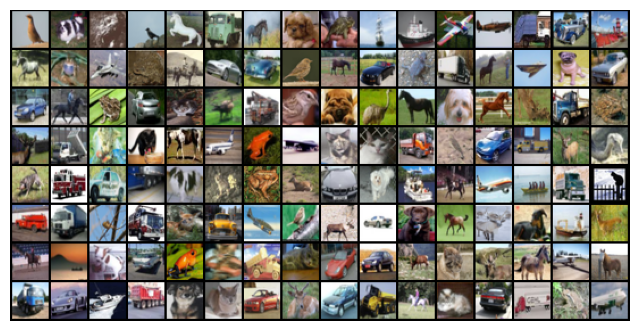

In [5]:
# num = 0
# image, label = tr_set[num]
# print("label: " + classes[(tr_set[num])[1]])
# plt.axis('off')
# plt.imshow(image.permute((1, 2, 0)))

for images, labels in tr_loader:
    plt.figure(figsize=(8,16))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

In [6]:
imgSize = 3*32*32  # 3072

# need to flatten 3x32x32 matrix image into single vector
class Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(imgSize, len(classes))
        
    def forward(self, x):
        x = x.reshape(-1, imgSize)
        output = self.linear(x)
        return output

In [7]:
# for images, labels in tr_loader:
#     linear_outputs = model(images)
#     probs = F.softmax(linear_outputs, dim=1)

In [8]:
# maxProbs, preds = torch.max(probs, dim=1)
# print(preds)
# print(maxProbs)
# print(preds==labels)

def accuracy(probs, labels):
    maxProbs, preds = torch.max(probs, dim=1)
    return torch.sum(preds==labels).item() / len(labels)


In [9]:
# loss_func = F.cross_entropy
# loss = loss_func(linear_outputs, labels)
# print(loss)

def lossPerBatch(model, loss_func, batch, opt=None):
    x, y_labels = batch
    linear_outputs = model(x)
    probs = F.softmax(linear_outputs, dim=1)
    
    # calc loss
    loss = loss_func(linear_outputs, y_labels)
    # calc accuracy
    acc = accuracy(probs, y_labels)

    # if opt None --> finding loss on validation set
    # else --> finding loss for training
    if opt is not None: # comp gradients, update params, reset gradients
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), acc, len(x)

In [10]:
def evaluate(model, loss_func, data_loader):
    results = [ lossPerBatch(model, loss_func, batch) for batch in data_loader ]
    batch_losses, batch_accs, batch_sizes = zip(*results)
    
    
#     avgLoss = torch.stack(batch_losses).mean()
#     avgAcc = torch.stack(batch_accs).mean()
    
#     batch_losses = [x['val_loss'] for x in outputs]
#     epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
#     batch_accs = [x['val_acc'] for x in outputs]
#     epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
#     return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}


    # avg loss and acc over all validation batches
    total = np.sum(batch_sizes)
    avgLoss = np.sum(np.multiply(batch_losses, batch_sizes)) / total
    avgAcc = np.sum(np.multiply(batch_accs, batch_sizes)) / total

    return avgLoss, avgAcc

In [15]:
def fit(epochs, model, loss_func, opt, tr_loader, val_loader, display=True):
    valResults = []
    
    for epoch in range(epochs):
        temp_size = 0
        num_printed = 1
        # train on each batch, opt required for training
        for batch in tr_loader:
            loss, acc, size = lossPerBatch(model, loss_func, batch, opt)
            temp_size += size
            if display and (temp_size >= 5000):
                print(f'- Epoch {epoch + 1}, ~{temp_size*num_printed} = Loss: {loss}, Acc: {acc}')
                temp_size = 0
                num_printed += 1

        # evaluate on val after one training epoch
        valResult = evaluate(model, loss_func, val_loader)
        valResults.append(valResult)
        
        # show validation results for each epoch
        if display:
            avgValLoss, avgValAcc = valResult
            print(f'Epoch [{epoch + 1}/{epochs}] = ValLoss: {avgValLoss}, ValAcc: {avgValAcc}')
            print('-------------------------')

    return valResults

In [22]:
# setup parameters
lr = 0.001
model = Logistic()
loss_func = F.cross_entropy
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

# training
print('--- Training Logistic Model...')
valResults = fit(15, model, loss_func, optimizer, tr_loader, val_loader)
print('--- Training Complete.')


--- Training Logistic Model...
- Epoch 1, ~5120 = Loss: 2.2890520095825195, Acc: 0.1171875
- Epoch 1, ~10240 = Loss: 2.2770183086395264, Acc: 0.1171875
- Epoch 1, ~15360 = Loss: 2.2364203929901123, Acc: 0.2109375
- Epoch 1, ~20480 = Loss: 2.1900124549865723, Acc: 0.2265625
- Epoch 1, ~25600 = Loss: 2.171215772628784, Acc: 0.265625
- Epoch 1, ~30720 = Loss: 2.178666591644287, Acc: 0.296875
- Epoch 1, ~35840 = Loss: 2.1703877449035645, Acc: 0.2578125
- Epoch 1, ~40960 = Loss: 2.209176540374756, Acc: 0.203125
Epoch [1/15] = ValLoss: 2.1272815643310548, ValAcc: 0.2752
-------------------------
- Epoch 2, ~5120 = Loss: 2.1185028553009033, Acc: 0.265625
- Epoch 2, ~10240 = Loss: 2.1188888549804688, Acc: 0.2265625
- Epoch 2, ~15360 = Loss: 2.031510829925537, Acc: 0.3515625
- Epoch 2, ~20480 = Loss: 2.0893490314483643, Acc: 0.28125
- Epoch 2, ~25600 = Loss: 2.0796449184417725, Acc: 0.2734375
- Epoch 2, ~30720 = Loss: 2.022012710571289, Acc: 0.3828125
- Epoch 2, ~35840 = Loss: 2.026746749877929

- Epoch 15, ~35840 = Loss: 1.9718433618545532, Acc: 0.3828125
- Epoch 15, ~40960 = Loss: 1.8161296844482422, Acc: 0.34375
Epoch [15/15] = ValLoss: 1.8615575799942017, ValAcc: 0.3556
-------------------------
--- Training Complete.


In [23]:
# evaluating
tr_loss, tr_acc = evaluate(model, loss_func, tr_loader)
val_loss, val_acc = evaluate(model, loss_func, val_loader)
te_loss, te_acc = evaluate(model, loss_func, te_loader)

print("training accuracy: ", tr_acc)
print("validation accuracy: ",val_acc)
print("test accuracy: ", te_acc)

training accuracy:  0.37006666666666665
validation accuracy:  0.3556
test accuracy:  0.3622


Text(0.5, 0.98, 'Loss and Accuracy vs. Epochs')

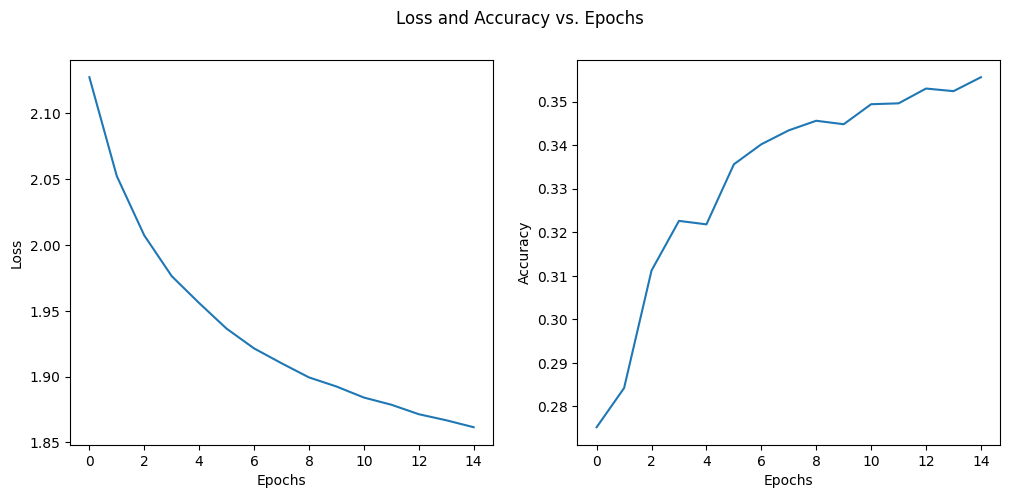

In [24]:
# plotting
fig, axes = plt.subplots(1, 2, figsize=(12,5))

losses, accs = zip(*valResults)

axes[0].plot(losses)
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')

axes[1].plot(accs)
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')

fig.suptitle('Loss and Accuracy vs. Epochs')

# losses = [loss for loss, _ in valResults]
# plt.plot(losses, '-'')
# plt.xlabel('epochs')
# plt.ylabel('loss')
# plt.title('Loss vs. # of Epochs');

# accuracies = [x['val_acc'] for x in history]
# plt.plot(accuracies, '-x')
# plt.xlabel('epoch')
# plt.ylabel('accuracy')
# plt.title('Accuracy vs. No. of epochs');

In [ ]:
cm = confusion_matrix(te_set, y_pred_te)
cm_disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
cm_disp.plot()